In [1]:
# TODO: Continuer à travailler la classe pour l'évaluation sur le jeu de test et finir le pipeline
# TODO: Intégrer les métriques du jeu de test

# README

#TODO Ce notebook présente une analyse de données sur les ventes de jeux vidéo. L'objectif est d'explorer les tendances des ventes en fonction de la plateforme, du genre et de la région.

# PRE-REQUIS

Ce bloc contient tout ce qui est nécessaire pour le fonctionnement des expériences.

## Imports & Configurations

In [2]:
import os
import warnings
from time import time
from datetime import datetime
from pathlib import PosixPath

import pandas as pd
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

from constants import ROOT_FOLDER, IMAGE_FOLDER, ARTIFACTS_FOLDER, DATASET_PATH
from constants import SEED, VAL_SIZE, TEST_SIZE, BATCH_SIZE, SAMPLING, INPUT_RESOLUTION

2025-05-05 16:45:05.703514: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746456305.723050   20232 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746456305.728384   20232 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746456305.743637   20232 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746456305.743658   20232 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746456305.743659   20232 computation_placer.cc:177] computation placer alr

## Préparation des données

### Chargement du dataset

In [3]:
# Loading the pickle dataset_cleaned used with the previous project as a pandas df
df = pd.read_pickle(DATASET_PATH).drop(columns=["product_name", "description"])
print(f"Dataset shape: {df.shape}")
print(f"Dataset columns: {df.columns}")

# Encode the labels with LabelEncoder
le = LabelEncoder()
le.fit(df["class"])
N_CLASSES = len(le.classes_)
CLASSES = le.classes_.tolist()
print(f"Number of classes: {N_CLASSES}")
print(f"Classes: {CLASSES}")

# Finally transform the class column to the encoded labels
df["class"] = le.transform(df["class"])

Dataset shape: (1050, 2)
Dataset columns: Index(['image', 'class'], dtype='object')
Number of classes: 7
Classes: ['Baby Care', 'Beauty and Personal Care', 'Computers', 'Home Decor & Festive Needs', 'Home Furnishing', 'Kitchen & Dining', 'Watches']


### Séparation des données (train/validation/test)

In [4]:
def split_dataset(df, train_path, val_path, test_path):
        # Splitting the datasets into train, val and test sets
        X_temp, X_test, y_temp, y_test = train_test_split(
            df["image"],
            df["class"],
            test_size=TEST_SIZE,
            random_state=SEED,
            stratify=df["class"],
            shuffle=True,
        )
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=VAL_SIZE, random_state=SEED, stratify=y_temp, shuffle=True
        )

        # Concat X and y for each set
        train = (
            pd.concat([X_train, y_train], axis=1).sample(SAMPLING)
            if SAMPLING
            else pd.concat([X_train, y_train], axis=1)
        )
        train.to_pickle(train_path)
        val = (
            pd.concat([X_val, y_val], axis=1).sample(SAMPLING)
            if SAMPLING
            else pd.concat([X_val, y_val], axis=1)
        )
        val.to_pickle(val_path)
        test = (
            pd.concat([X_test, y_test], axis=1).sample(SAMPLING)
            if SAMPLING
            else pd.concat([X_test, y_test], axis=1)
        )
        test.to_pickle(test_path)
    
def load_splits(train_path, val_path, test_path): 
    # Load the saved files if they exist
    try:
        train = pd.read_pickle(train_path)
        val = pd.read_pickle(val_path)
        test = pd.read_pickle(test_path)
    except FileNotFoundError as e:
            print(e)
            print("This file has not been found. Please check the paths before.")
    
    # Finally print the shapes of the datasets
    print(f"Train shape: {train.shape}")
    print(f"Val shape: {val.shape}")
    print(f"Test shape: {test.shape}")

    return train, val, test

In [5]:
# Define the path to save the splitted cleaned datasets
completion = SAMPLING if SAMPLING else "full"
train_path = ROOT_FOLDER / "data" / f"trainset_{completion}.pickle"
val_path = ROOT_FOLDER / "data" / f"valset_{completion}.pickle"
test_path = ROOT_FOLDER / "data" / f"testset_{completion}.pickle"

# Load the splitted datasets if they exist
if os.path.exists(train_path) and os.path.exists(val_path) and os.path.exists(test_path):
    train, val, test = load_splits(train_path, val_path, test_path)
else:
    # If the one or more files do not exist, split the dataset and save/overwrite the files
    split_dataset(df, train_path, val_path, test_path)
    train, val, test = load_splits(train_path, val_path, test_path)

Train shape: (758, 2)
Val shape: (134, 2)
Test shape: (158, 2)


In [6]:
train.head(5)

,image,class
229,caabe6014b914fe2874a9a8d7284f79b.jpg,3
450,95feec21a9d076cff084159d61bf9b8e.jpg,0
798,9993de7e2bcced43dc9edb3b2c81f23d.jpg,1
230,968a2b3be84193e3f755c2fe71033a2c.jpg,3
293,c2efa8aa11898bdb5fc4e46201973a42.jpg,0


In [7]:
val.head(5)

,image,class
979,c44a5dc5b5ebe5b3e0535b7c2b7921e4.jpg,0
49,02a53d335775b652f22f41b529b9d646.jpg,1
567,97fba8a02361aa56eaa9fa51bc1d7661.jpg,6
494,a124d6e4c30b00918c594289266a383c.jpg,6
773,109e235d4838002246599f987d935c21.jpg,0


In [8]:
test.head(5)

,image,class
11,08452abdadb3db1e686b94a9c52fc7b6.jpg,6
548,2541b59d54a3a9f2681c0049f7ddd85c.jpg,6
696,82fbc93cd45ab747e7e606f2c52c7335.jpg,3
238,2e8df36b35d22cf219cf8bae6c2af752.jpg,5
963,bcb51cec3d290e6a661586d0df30e091.jpg,4


## Classes et Fonctions

### DataLoader

In [9]:
# Block DataLoader

class ImageDataset(tf.keras.utils.Sequence):
    def __init__(
        self,
        dataframe: pd.DataFrame,
        image_dir: PosixPath,
        processor = None,
        **kwargs,
    ):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame containing image file names and labels.
            image_dir (PosixPath): Directory where images are stored.
            processor (AutoImageProcessor, optional): Hugging Face processor for image preprocessing. Defaults to None.
        """
        super().__init__(**kwargs)
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.processor = processor

    def __len__(self):
        return int(np.ceil(len(self.dataframe) / BATCH_SIZE))

    def __getitem__(self, idx):
        batch_data = self.dataframe.iloc[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE, :]
        images = []
        labels = []

        for _, row in batch_data.iterrows():
            name, label = row
            img_name = self.image_dir / name  # Assuming image file names are in the first column
            image = Image.open(img_name).convert("RGB")  # Ensure consistent color format
            image = image.resize((INPUT_RESOLUTION[0], INPUT_RESOLUTION[1]), Image.Resampling.BILINEAR)  # Resize to model input size

            if self.processor:
                image = self.processor(image)

            images.append(np.array(image))
            labels.append(label)

        # Convert to TensorFlow tensors
        images = tf.convert_to_tensor(images)
        labels = tf.convert_to_tensor(labels)
        labels = tf.one_hot(labels, depth=N_CLASSES)

        return images, labels

In [10]:
train_dataset = ImageDataset(
    train,
    image_dir=IMAGE_FOLDER,
    processor=preprocess_input,
)
val_dataset = ImageDataset(
    val,
    image_dir=IMAGE_FOLDER,
    processor=preprocess_input,
)
test_dataset = ImageDataset(
    test,
    image_dir=IMAGE_FOLDER,
    processor=preprocess_input,
)

In [11]:
# Enregistre les paramètres du modèle
model_params = {
    'include_top': False,
    'weights': 'imagenet',
    'input_shape': (224, 224, 3)
}

# Charge le modèle EfficientNetB0
model = EfficientNetB0(**model_params)

# Affiche les couches du modèle d'entrée et de sortie
print("Input: ", model.input)
print("Output: ", model.output)

# Ajoute les dernières couches denses du modèle
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(N_CLASSES, activation='softmax', name='predictions')(x)

# Crée un modèle à partir des inputs et des outputs
model = Model(inputs=model.input, outputs=predictions)


I0000 00:00:1746456322.710207   20232 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2246 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Input:  <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor>
Output:  <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, ragged=False, name=keras_tensor_237>


In [12]:
model.compile(
        optimizer=Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

In [13]:
# Définit le nom du modèle à charger
model_name = ARTIFACTS_FOLDER / "effnet.weights.h5"

# Charger les poids du modèle sauvegardés
model.load_weights(model_name)

# Évaluer le modèle avec les poids chargés
score = model.evaluate(test_dataset, verbose=1)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")


/home/hedredo/github/oc_p9/notebook-tf/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 432 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
I0000 00:00:1746456342.732572   20347 service.cc:152] XLA service 0x7fc640048e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746456342.732624   20347 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-05-05 16:45:43.241330: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746456343.952680   20347 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8750 - loss: 0.3921 

I0000 00:00:1746456349.571914   20347 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 802ms/step - accuracy: 0.7738 - loss: 0.6847
Test loss: 0.6549811959266663
Test accuracy: 0.7911392450332642


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 475ms/step
Inference time: 11.77 seconds
                            precision    recall  f1-score   support

                 Baby Care       0.92      0.52      0.67        23
  Beauty and Personal Care       0.66      0.83      0.73        23
                 Computers       0.73      0.86      0.79        22
Home Decor & Festive Needs       0.78      0.78      0.78        23
           Home Furnishing       0.74      0.77      0.76        22
          Kitchen & Dining       0.86      0.78      0.82        23
                   Watches       0.96      1.00      0.98        22

                  accuracy                           0.79       158
                 macro avg       0.81      0.79      0.79       158
              weighted avg       0.81      0.79      0.79       158



<Figure size 1000x800 with 0 Axes>

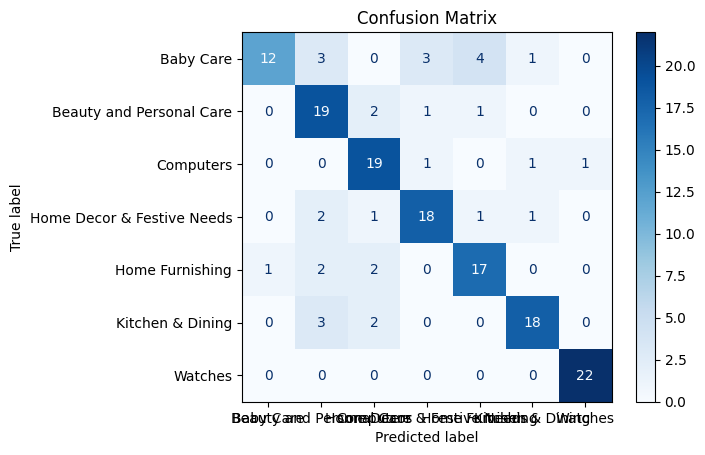

In [14]:
# Warm-up the model (optional but recommended for accurate timing)
_ = model.predict(test_dataset, verbose=0)
start_time = time()
predictions = model.predict(test_dataset)
end_time = time()
inference_time = end_time - start_time
print(f"Inference time: {inference_time:.2f} seconds")
predicted_classes = np.argmax(predictions, axis=1)
# Get true labels
true_labels = test["class"].values
# Generate classification report
report = classification_report(true_labels, predicted_classes, target_names=CLASSES)
print(report)
# Generate confusion matrix
cm = tf.math.confusion_matrix(true_labels, predicted_classes, num_classes=N_CLASSES)
# Plot confusion matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_matrix=cm.numpy(), display_labels=CLASSES).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()